# **Bonabeau model**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random as rd
import os
import tqdm

In [2]:
"""agent class"""

class Agent:
    def __init__(
        self,
        init_position: tuple[int],
        init_fitness: float,
        id=int,
    ):
        self.position_hist = [init_position]
        self.fitness_hist = [init_fitness]
        self.Pi_hist = [] 
        self.id = id
        self._Pi = None

    @property
    def position(self):
        return self.position_hist[-1]

    @property
    def fitness(self):
        return self.fitness_hist[-1]
    
    @property
    def Pi(self):
        return self._Pi

    @Pi.setter
    def Pi(self, value):
        self._Pi = value
        self.Pi_hist.append(value)

    def add_unchanged_step(self):
        self.fitness_hist.append(self.fitness)

    def move_position(self, L):
        x, y = self.position

        move_axis = np.random.choice([0, 1])

        if move_axis == 0:
            dx = np.random.choice([-1, 1])
            x = int(np.clip(x + dx, 0, L-1))
        else:
            dy = np.random.choice([-1, 1])
            y = int(np.clip(y + dy, 0, L-1))
        self.position_hist.append((x, y))


In [3]:
"""game class"""

import numpy as np
import tqdm

class Game:
    def __init__(
        self,
        N: int,
        mu: float,
        grid_size: int = 20,
        eta: float = 10,
    ):
        # input args
        self.N = N
        self.mu = mu
        self.grid_size = grid_size
        self.eta = eta

        # deduced args
        self.rho = self.N / (self.grid_size**2)

        # population and grid (fitness init is included)
        self.population = []
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        self.init_population()

        # plots 
        self.tracked_ids = np.random.choice(self.N, size=10, replace=False)

    def play_game(self, t_max: int, save_every: int | None = None):
        """Plays according to the diagram of the paper."""
        print(f"Rho : {self.rho}")
        for t in tqdm.tqdm(range(t_max)):
            self.play_one_iter()
            if save_every is not None and t % save_every == 0:
                self.plot_current_situation(t)
        self.plot_tracked_Pi()

    def play_one_iter(self):
        """Play one iteration of the game"""
        # move
        self.move_all_agents()

        # check and fight and update fitnesses
        self.check_and_do_fight()

        # relaxation term for all
        for agent in self.population:
            relaxed_fitness = agent.fitness - self.mu * np.tanh(agent.fitness)
            agent.fitness_hist[-1] = relaxed_fitness

        # <Pi> computation
        self.update_all_Pi()

    def check_and_do_fight(self):
        """Checks if a fight should take place and does it in such a case."""
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                agents = self.grid[x][y]
                if agents and len(agents) > 1:
                    self.fight(agents[0], agents[1])
                    for a in agents[2:]:
                        a.add_unchanged_step()
                elif agents and len(agents) == 1:
                    agents[0].add_unchanged_step()

    def move_all_agents(self):
        """Move all agents by one step and update the grid."""
        # reset grid
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]

        for agent in self.population:
            agent.move_position(self.grid_size)
            x, y = agent.position
            self.grid[x][y].append(agent)

    def fight(self, agent_i, agent_j):
        hi, hj = agent_i.fitness, agent_j.fitness
        prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))

        if np.random.rand() < prob_i_wins:
            agent_i.fitness_hist.append(hi + 1)
            agent_j.fitness_hist.append(hj - 1)
        else:
            agent_i.fitness_hist.append(hi - 1)
            agent_j.fitness_hist.append(hj + 1)

    def update_all_Pi(self):
        """Compute and update Pi for all agents based on current fitness."""
        if self.N <= 1:
            for agent in self.population:
                agent.Pi = 0.0
            return

        for agent_i in self.population:
            hi = agent_i.fitness
            total = 0.0
            for agent_j in self.population:
                if agent_j.id == agent_i.id:
                    continue
                hj = agent_j.fitness
                total += 1 / (1 + np.exp(self.eta * (hj - hi)))
            agent_i.Pi = total / (self.N - 1)

    def init_population(self):
        """Place N agents at random positions on the grid with initial fitness = 0.0"""
        positions = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]

        if self.N > len(positions):
            raise ValueError("Grid is too small to place all agents without overlap.")

        np.random.shuffle(positions)

        for i in range(self.N):
            pos = positions[i]
            agent = Agent(init_position=pos, init_fitness=0.0, id=i)
            self.population.append(agent)
            x, y = pos
            self.grid[x][y].append(agent)

    def plot_tracked_Pi(self):
        plt.figure(figsize=(10, 6))
        for i in self.tracked_ids:
            agent = self.population[i]
            plt.plot(agent.Pi_hist, label=f"Agent {i}")
        plt.xlabel("Temps")
        plt.ylabel(r"$\Pi$")
        plt.title("Évolution de $\Pi$ pour 10 agents")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


<>:129: SyntaxWarning: invalid escape sequence '\P'
<>:129: SyntaxWarning: invalid escape sequence '\P'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_24617/3441281453.py:129: SyntaxWarning: invalid escape sequence '\P'
  plt.title("Évolution de $\Pi$ pour 10 agents")


In [10]:
game = Game(
    N=20,         # nombre d'agents
    mu=0.1,       # relaxation
    grid_size=10, # taille de la grille
    eta=5       # paramètre dans les proba de victoire
)

Rho : 0.1


100%|██████████| 10000/10000 [00:05<00:00, 1772.05it/s]


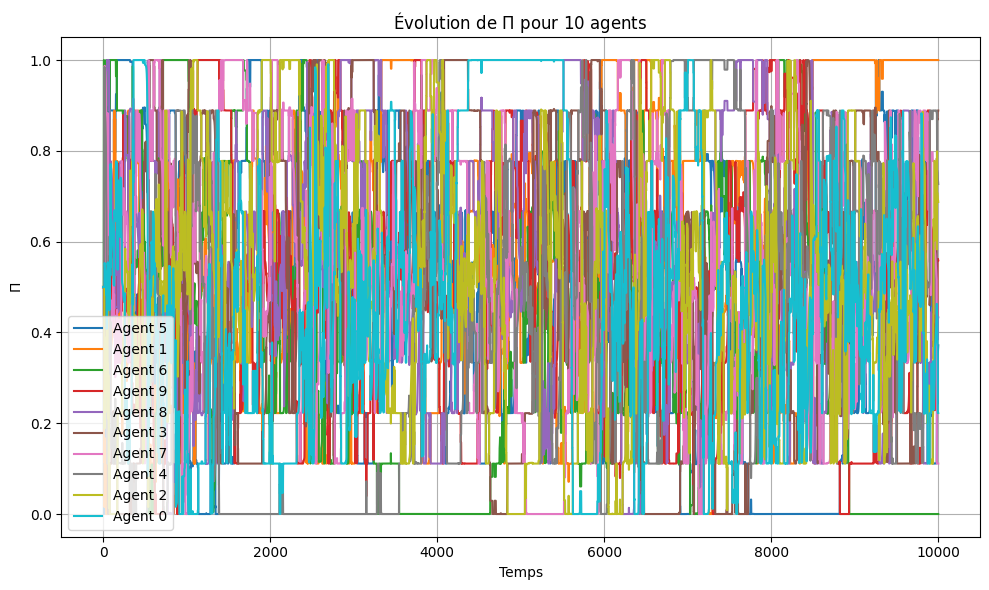

In [12]:
### Rho 0.1 ==> Eratic

game = Game(
    N=10,         # nombre d'agents
    mu=0.1,       # relaxation
    grid_size=10, # taille de la grille
    eta=5       # paramètre dans les proba de victoire
)

game.play_game(t_max=10000)

Rho : 0.2


  9%|▉         | 887/10000 [00:01<00:13, 666.69it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_24617/3441281453.py:103: RuntimeWarning: overflow encountered in exp
  total += 1 / (1 + np.exp(self.eta * (hj - hi)))
 10%|█         | 1029/10000 [00:01<00:13, 687.54it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_24617/3441281453.py:80: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 10000/10000 [00:15<00:00, 633.57it/s]


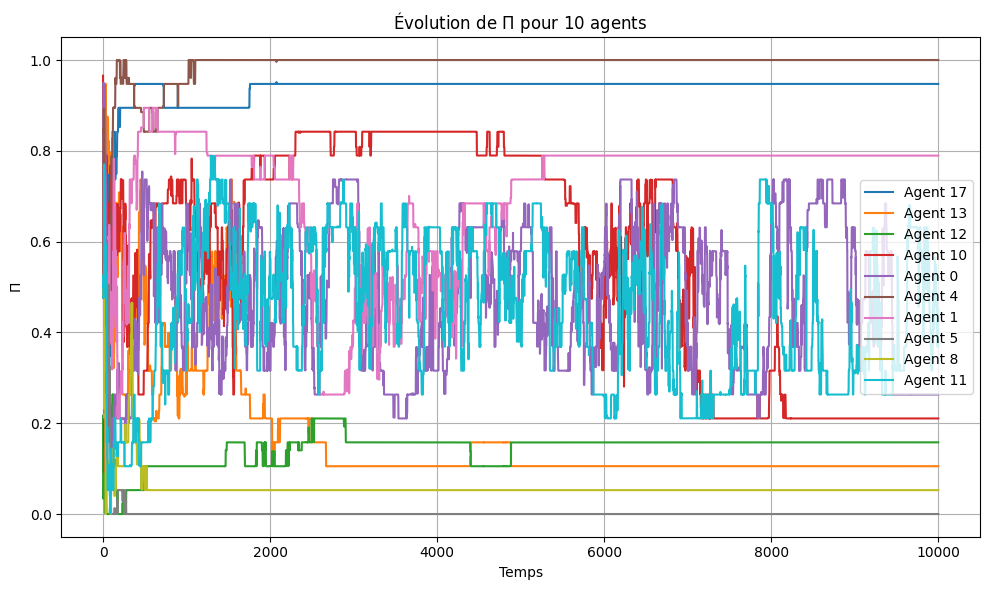

In [11]:
### Rho 0.2

game = Game(
    N=20,         # nombre d'agents
    mu=0.1,       # relaxation
    grid_size=10, # taille de la grille
    eta=5       # paramètre dans les proba de victoire
)

game.play_game(t_max=10000)

Rho : 0.5


  2%|▏         | 200/10000 [00:01<01:07, 145.86it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_24617/3441281453.py:103: RuntimeWarning: overflow encountered in exp
  total += 1 / (1 + np.exp(self.eta * (hj - hi)))
  2%|▏         | 216/10000 [00:01<01:06, 147.77it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_24617/3441281453.py:80: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 10000/10000 [01:17<00:00, 128.29it/s]


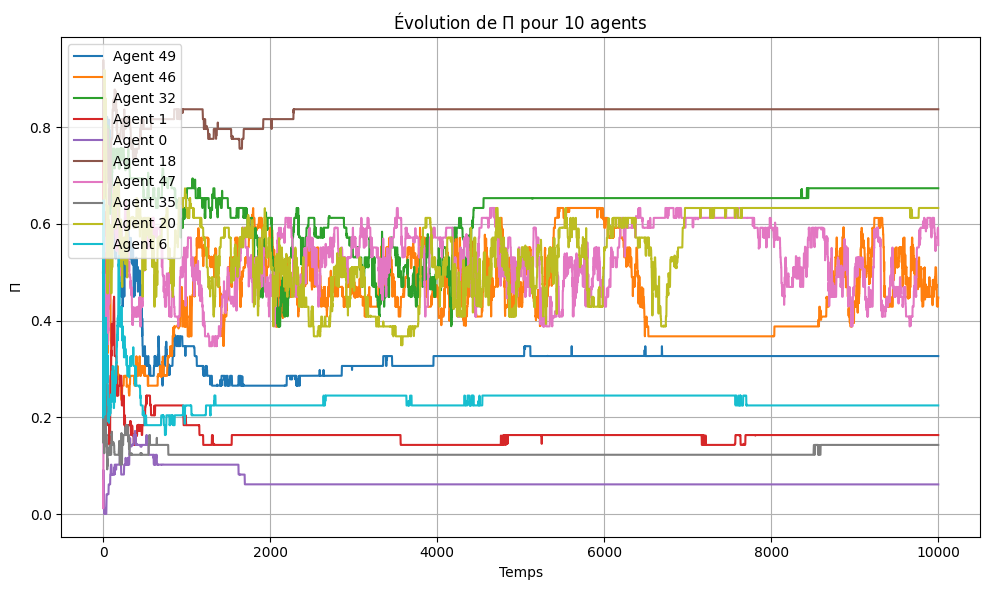

In [13]:
### Rho 0.5 >> rho C

game = Game(
    N=50,         # nombre d'agents
    mu=0.1,       # relaxation
    grid_size=10, # taille de la grille
    eta=5       # paramètre dans les proba de victoire
)

game.play_game(t_max=10000)

Rho : 0.7


  2%|▏         | 157/10000 [00:01<01:47, 91.78it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_24617/3441281453.py:103: RuntimeWarning: overflow encountered in exp
  total += 1 / (1 + np.exp(self.eta * (hj - hi)))
  2%|▏         | 187/10000 [00:02<01:46, 91.89it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_24617/3441281453.py:80: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 10000/10000 [02:23<00:00, 69.76it/s]


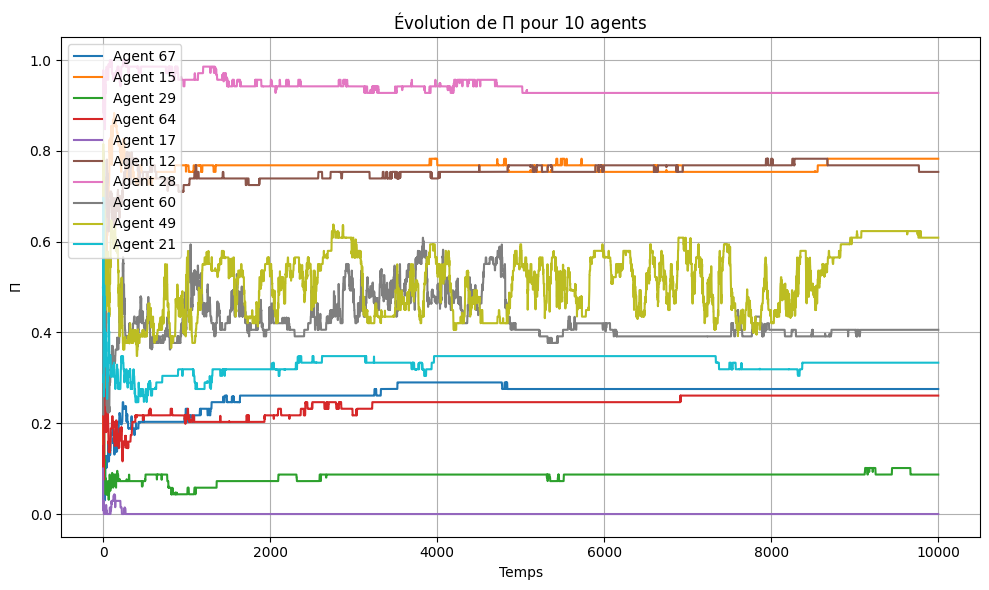

In [14]:
### Rho 0.7 >> rho C

game = Game(
    N=70,         # nombre d'agents
    mu=0.1,       # relaxation
    grid_size=10, # taille de la grille
    eta=5       # paramètre dans les proba de victoire
)

game.play_game(t_max=10000)